In [46]:
import pandas as pd
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

with open('../config/repository_path.txt', 'r') as reader:
    repository_path=reader.read().strip()
sys.path.append(repository_path)

from lib import models
from lib import dataset
from lib import tdmstudio

In [43]:
# ----- #
# INPUT #
# ----- #
labeled_data_file = '/home/ec2-user/SageMaker/mariano/datasets/refugees/deserving_refugees/labeled_data_2023-06-21.csv'


In [44]:
threshold = 0.008323624080433243 # threshold at iteration j=52 LOOP=52

In [45]:
labeled_data_df = pd.read_csv(labeled_data_file)

with open(os.path.join(repository_path, 'embeddings', 'item_representation_50k_final.pickle'), 'rb') as reader:
    item_representation=pickle.load(reader)

print(f"Relevant count={len([label for label in labeled_data_df['label'] if label=='R'])}")
print(f"Relevant count={len([label for label in labeled_data_df['label'] if label=='I'])}")
      
labeled_collection = []      
for id_, label in zip(labeled_data_df['id'], labeled_data_df['label']):
      item = dataset.DataItemRefugees(str(id_))
      item.assign_label(label)
      labeled_collection.append(item)
print(len([item for item in labeled_collection if item.is_relevant()]))
print(len([item for item in labeled_collection if item.is_irrelevant()]))

Relevant count=90
Relevant count=188
90
188


In [5]:
model = models.LogisticRegressionRefugees()
model.fit(labeled_collection, item_representation=item_representation)

In [6]:
count=0
for item_representation_file in os.listdir(os.path.join(repository_path, 'embeddings')):
    output_file = os.path.join(repository_path,'data','predictions', item_representation_file[:-7]+ '.csv')
    if not os.path.isfile(output_file):
#         print(output_file)
        data = {'id': [], 'label':[],  'score': []}
        with open(os.path.join(repository_path, 'embeddings', item_representation_file), 'rb') as reader:
            item_representation = pickle.load(reader)
            unlabeled = [dataset.DataItemRefugees(id_) for id_ in item_representation]
            for item in unlabeled:
                item.set_irrelevant()
            yhat = model.predict(unlabeled, item_representation)
            relevant = yhat>threshold
            df = pd.DataFrame({'id': [item.id_ for item in unlabeled]})
            df['label']=['R' if score>threshold else 'I' for score in yhat]
            df['score']=yhat
            print(f'Working on file {item_representation_file:30} - Found {len(item_representation):7,} items - Found {np.sum(yhat>threshold):7,} relevant')

            df.to_csv(output_file, index=False)


Working on file item_representation_15.pickle  - Found  50,000 items - Found  50,000 relevant
Working on file item_representation_32.pickle  - Found  50,000 items - Found  50,000 relevant
Working on file item_representation_31.pickle  - Found  50,000 items - Found  50,000 relevant
Working on file item_representation_10.pickle  - Found  50,000 items - Found  50,000 relevant
Working on file item_representation_37.pickle  - Found  50,000 items - Found  50,000 relevant
Working on file item_representation_29.pickle  - Found  50,000 items - Found  50,000 relevant
Working on file item_representation_16.pickle  - Found  50,000 items - Found  50,000 relevant
Working on file item_representation_9.pickle   - Found  50,000 items - Found  50,000 relevant
Working on file item_representation_20.pickle  - Found  50,000 items - Found  50,000 relevant
Working on file item_representation_59.pickle  - Found  50,000 items - Found  50,000 relevant
Working on file item_representation_7.pickle   - Found  50,0

In [2]:
data={}
for file in os.listdir(os.path.join(repository_path, 'data','predictions')):
    df = pd.read_csv(os.path.join(repository_path, 'data','predictions',file))
    for id_, score in zip(df['id'], df['score']):
        if not id_ in data:
            data[id_]=score
        else:
            assert data[id_]-score<1e-6, f'{data[id_]},{score}'
    


In [3]:
ids=list(data)
all_scores = pd.DataFrame({'id':ids, 'score':[data[id_] for id_ in data]})

(array([2.712220e+05, 1.677947e+06, 1.298294e+06, 7.023880e+05,
        3.832370e+05, 2.194320e+05, 1.262870e+05, 7.262100e+04,
        4.187000e+04, 2.412800e+04, 1.402700e+04, 8.339000e+03,
        5.142000e+03, 3.360000e+03, 2.166000e+03, 1.578000e+03,
        1.165000e+03, 8.780000e+02, 7.050000e+02, 5.610000e+02,
        4.160000e+02, 3.350000e+02, 2.810000e+02, 2.080000e+02,
        1.820000e+02, 1.350000e+02, 1.000000e+02, 9.100000e+01,
        6.500000e+01, 5.400000e+01, 3.900000e+01, 3.200000e+01,
        1.900000e+01, 7.000000e+00, 2.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([0.01062185, 0.02912999, 0.04763813, 0.06614626, 0.0846544 ,
        0.10316253, 0.12167067, 0.1401788 , 0.15868694, 0.17719508,
        0.19570321, 0.21421135, 0.23271948, 0.25122762, 0.26973575,
        0.28824389, 0.30675203, 0.32526016, 0.3437683 , 0.36227643,
        0.38078457, 0.3992927 , 0.41780084, 0.43630898, 0.45481711,
        0.47332525

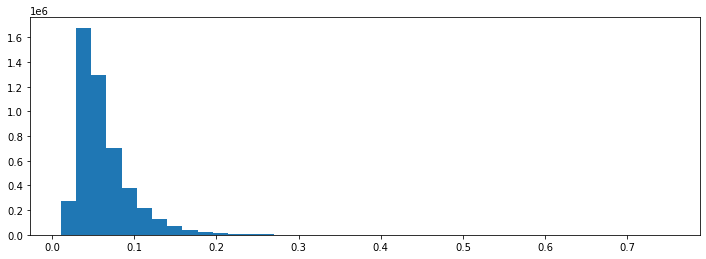

In [9]:
fig, ax = plt.subplots(1, figsize=(12,4))
ax.hist(all_scores['score'], bins=40)

In [9]:
len(set(all_predictions['id']))

4857316

In [21]:
for t in [0.0140689053561515, 0.0130186941135868, 0.0133909897906517, 0.0130760798450588, 0.0122304890254453,\
          0.0111699274771209, 0.00958888240990832, 0.00832362408043324, 0.007510179951379810]:
    print(f"{np.sum(all_scores['score']>t):,}")

4,857,180
4,857,273
4,857,249
4,857,272
4,857,306
4,857,315
4,857,316
4,857,316
4,857,316


Text(0, 0.5, '%')

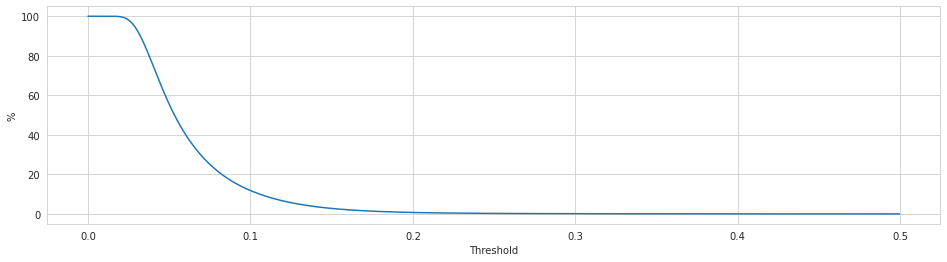

In [27]:
sns.set_style('whitegrid')
x=[]
y=[]
for ix in range(0,1000):
    threshold=ix/2000
    x.append(threshold)
    y.append((np.sum(all_scores['score']>threshold)/len(all_scores))*100)
fig, ax =plt.subplots(1, figsize=(16,4))
ax.plot(x,y)

ax.set_xlabel('Threshold')
ax.set_ylabel('%')

In [39]:
suggestions3k = all_scores.sort_values(by='score', ascending=False).iloc[:3000,:]

suggestions3k['title'] = list(map(tdmstudio.get_title, map(tdmstudio.get_filename, [str(id_) for id_ in suggestions3k['id']])))

In [42]:
suggestions3k.to_csv(os.path.join(repository_path, 'data', 'suggestions3k.csv'), index=False)

In [41]:
!pwdx

/home/ec2-user/SageMaker/mariano/repositories/refugee-research-problem-hrir/notebooks


In [ ]:
len(labeled)